# Import & IO


In [1]:
from io import BytesIO
from PIL import Image
import matplotlib.pyplot as plt
import math
import time

In [2]:
def imOpen(imageFileName):
    buffer = BytesIO()
    imageFile = open(imageFileName, 'rb')
    buffer.write(imageFile.read())
    buffer.seek(0)
    imageFile.close()

    originalImage = Image.open(buffer)

    width = originalImage.size[0]
    height = originalImage.size[1]
    image = Image.new('L', (width,height))
    for x in range(0, width):
        for y in range(0, height):
            r, g, b = originalImage.getpixel((x, y))
            color = 0.3 * r + 0.59 * g + 0.11 * b
            image.putpixel((x, y), int(color))
    
    return image

In [3]:
def displayImage(image):
  plt.imshow(image, cmap="gray")

In [4]:
def convertImageToArray(image):
  pixels = list(image.getdata())
  width, height = image.size
  pixels = list(image.getdata())
  return [[pixels[i * width + j] for j in range(width)] for i in range(height)]

# Integral Image and Local Sum Calculation

In [5]:
def CalculateIntegral(imageArray):
  n = len(imageArray)
  m = len(imageArray[0])
  ii = [[0 for j in range(m)] for i in range(n)]
  for i in range(n):
    for j in range(m):
      cell = imageArray[i][j]
      if i > 0:
        cell += ii[i - 1][j]
      if j > 0:
        cell += ii[i][j - 1]
      if i > 0 and j > 0:
        cell -= ii[i - 1][j - 1]
      ii[i][j] = cell
  return ii

In [6]:
def CalculateLocalSum(ii, p0, p1):
  endPointRow, endPointCol = p1[0], p1[1]
  startPointRow, startPointCol = p0[0], p0[1]

  sum = ii[endPointRow][endPointCol]

  if startPointRow > 0:
    sum -= ii[startPointRow - 1][endPointCol]

  if startPointCol > 0:
    sum -= ii[endPointRow][startPointCol - 1]

  if startPointRow > 0 and startPointCol > 0:
    sum += ii[startPointRow - 1][startPointCol - 1]

  return sum

# Kernel Convolution

In [7]:
def prewittKernal(x, y, ii, kernalSize):
  midStep = kernalSize // 2
  
  h1Upper = CalculateLocalSum(ii, (y - midStep, x - midStep), (y - 1, x + midStep))
  h1Lower = CalculateLocalSum(ii, (y + 1, x - midStep), (y + midStep, x + midStep))
  h1 = h1Upper - h1Lower

  h2Left = CalculateLocalSum(ii, (y - midStep, x - midStep), (y + midStep, x - 1))
  h2Right = CalculateLocalSum(ii, (y - midStep, x + 1), (y + midStep, x + midStep))
  h2 = h2Right - h2Left

  return math.sqrt(h1 ** 2 + h2 ** 2)

def laplaceKernal(x, y, ii, kernalSize):
  midStep = kernalSize // 2

  allSum = CalculateLocalSum(ii, (y - midStep, x - midStep), (y + midStep, x + midStep))
  middle = CalculateLocalSum(ii, (y, x), (y, x))

  result = -allSum + middle + middle * (kernalSize ** 2 - 1)

  return abs(result)

def meanKernal(x, y, ii, kernalSize):
  midStep = kernalSize // 2

  sum = CalculateLocalSum(ii, (y - midStep, x - midStep), (y + midStep, x + midStep))
  
  return sum // (kernalSize ** 2)

In [8]:
def EdgeDetect(ii, kernalSize):
  width = len(ii[0])
  height = len(ii)
  prewitt = [[0 for x in range(width)] for y in range(height)]
  laplace = [[0 for x in range(width)] for y in range(height)]
  midStep = kernalSize // 2
  for y in range(midStep, height - midStep):
    for x in range(midStep, width - midStep):
      prewitt[y][x] = prewittKernal(x, y, ii, kernalSize)
      laplace[y][x] = laplaceKernal(x, y, ii, kernalSize)
  return prewitt, laplace

In [9]:
def RefineEdge(ii, kernalSize, ratio):
  width = len(ii[0])
  height = len(ii)
  refined = [[0 for x in range(width)] for y in range(height)]
  midStep = kernalSize // 2
  for y in range(midStep, height - midStep):
    for x in range(midStep, width - midStep):
      meanAverage = meanKernal(x, y, ii, kernalSize)
      pixelValue = CalculateLocalSum(ii, (y, x), (y, x))
      if pixelValue > meanAverage * ratio:
        refined[y][x] = pixelValue
      else:
        refined[y][x] = 0
  return refined

# Test

In [10]:
# Load images
l4 = imOpen("inputs/L4.jpg")
l4b = imOpen("inputs/L4b.jpg")

In [11]:
# Calculate integral image for both images
iiL4 = CalculateIntegral(convertImageToArray(l4))
iiL4b = CalculateIntegral(convertImageToArray(l4b))

In [12]:
# Calculate first and second derivatives for the first image
startTime = time.time()
l4D1, l4D2 = EdgeDetect(iiL4, 121)
endTime = time.time()
print("Done in", int((endTime - startTime) * 1000), 'ms')

Done in 98464 ms


# Plotting Results image L4

# first and second deriv different kernel size 

In [24]:
# kernel size 11, 51, 101, and 121 first and second driv. for image 1

l4D1k11, l4D2k11 = EdgeDetect(iiL4, 11)
l4D1k51, l4D2k51 = EdgeDetect(iiL4, 51)
l4D1k101, l4D2k101 = EdgeDetect(iiL4, 101)
l4D1k121, l4D2k121 = EdgeDetect(iiL4, 121)


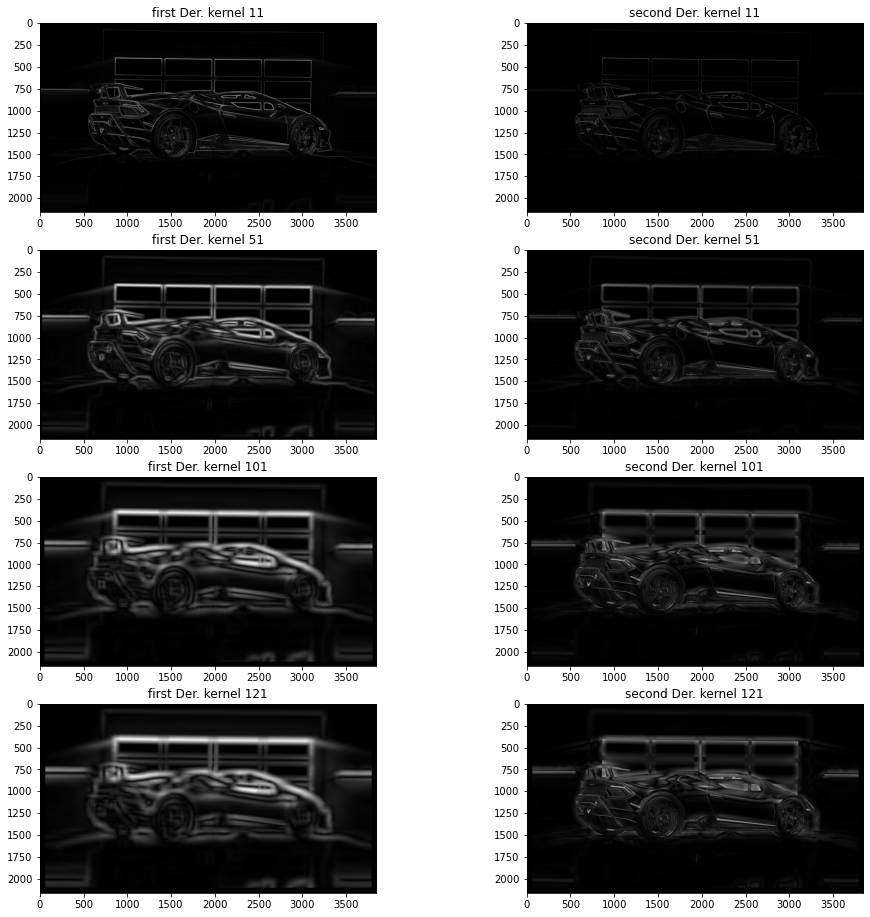

In [25]:
queuePlot = []
queueTile = []
w=10
h=10
fig=plt.figure(figsize=(16, 16))
columns = 2
rows = 4

queuePlot.append(l4D1k11)
queuePlot.append(l4D2k11)
queuePlot.append(l4D1k51)
queuePlot.append(l4D2k51)
queuePlot.append(l4D1k101)
queuePlot.append(l4D2k101)
queuePlot.append(l4D1k121)
queuePlot.append(l4D2k121)

queueTile.append("first Der. kernel 11")
queueTile.append("second Der. kernel 11")
queueTile.append("first Der. kernel 51")
queueTile.append("second Der. kernel 51")
queueTile.append("first Der. kernel 101")
queueTile.append("second Der. kernel 101")
queueTile.append("first Der. kernel 121")
queueTile.append("second Der. kernel 121")

for i in range(1, 8+1):
    fig.add_subplot(rows, columns, i)
    plt.title(queueTile.pop(0)) 
    plt.imshow(queuePlot.pop(0), cmap="gray")

plt.show()

# Refined edges for detected edge image with kernal size 11 wi refined edge with size 51 and different ratios

In [26]:
iil4D1k11 = CalculateIntegral(l4D1k11)
iil4D2k11 = CalculateIntegral(l4D2k11)

l4D1k11R1 = RefineEdge(iil4D1k11, 51, 1)
l4D2k11R1 = RefineEdge(iil4D2k11, 51, 1)

l4D1k11R2 = RefineEdge(iil4D1k11, 51, 1.05)
l4D2k11R2 = RefineEdge(iil4D2k11, 51, 1.05)

l4D1k11R3 = RefineEdge(iil4D1k11, 51, 1.15)
l4D2k11R3 = RefineEdge(iil4D2k11, 51, 1.15)

l4D1k11R4 = RefineEdge(iil4D1k11, 51, 1.25)
l4D2k11R4 = RefineEdge(iil4D2k11, 51, 1.25)

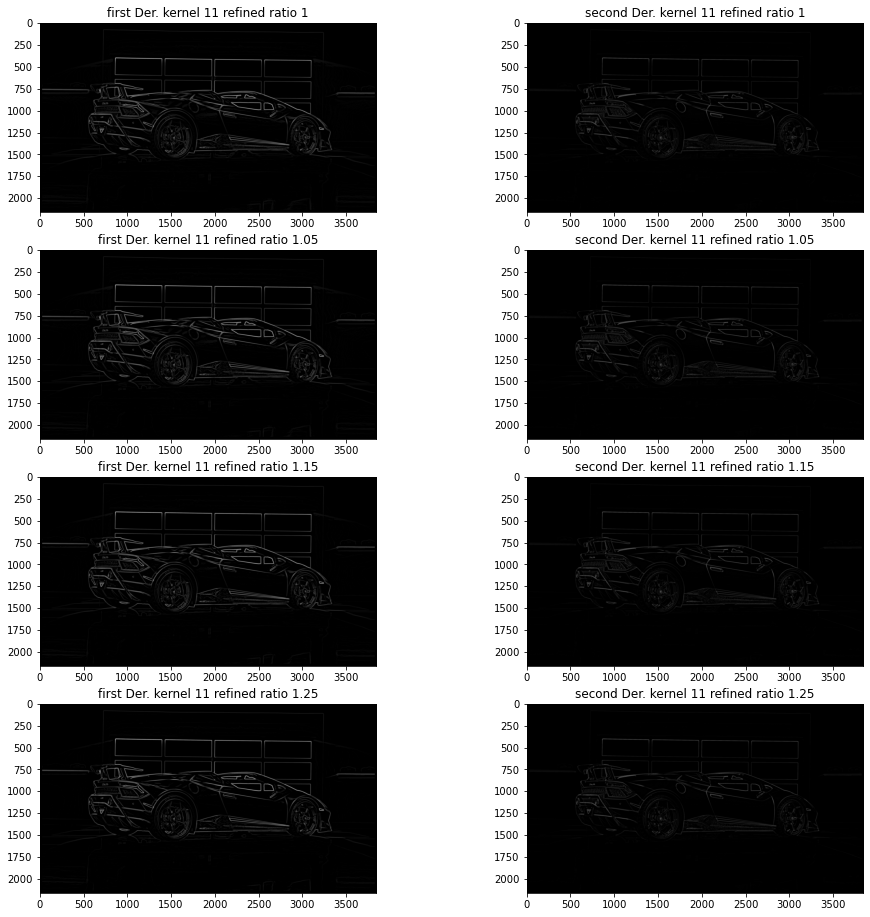

In [27]:
queuePlot = []
queueTile = []
w=10
h=10
fig=plt.figure(figsize=(16, 16))
columns = 2
rows = 4

queuePlot.append(l4D1k11R1)
queuePlot.append(l4D2k11R1)
queuePlot.append(l4D1k11R2)
queuePlot.append(l4D2k11R2)
queuePlot.append(l4D1k11R3)
queuePlot.append(l4D2k11R3)
queuePlot.append(l4D1k11R4)
queuePlot.append(l4D2k11R4)

queueTile.append("first Der. kernel 11 refined ratio 1")
queueTile.append("second Der. kernel 11 refined ratio 1")
queueTile.append("first Der. kernel 11 refined ratio 1.05")
queueTile.append("second Der. kernel 11 refined ratio 1.05")
queueTile.append("first Der. kernel 11 refined ratio 1.15")
queueTile.append("second Der. kernel 11 refined ratio 1.15")
queueTile.append("first Der. kernel 11 refined ratio 1.25")
queueTile.append("second Der. kernel 11 refined ratio 1.25")

for i in range(1, 8+1):
    fig.add_subplot(rows, columns, i)
    plt.title(queueTile.pop(0)) 
    plt.imshow(queuePlot.pop(0), cmap="gray")

plt.show()

# Refined edges for detected edge image with kernal size 51 wi refined edge with size 51 and different ratios

In [28]:
iil4D1k51 = CalculateIntegral(l4D1k51)
iil4D2k51 = CalculateIntegral(l4D2k51)

l4D1k51R1 = RefineEdge(iil4D1k51, 51, 1)
l4D2k51R1 = RefineEdge(iil4D2k51, 51, 1)

l4D1k51R2 = RefineEdge(iil4D1k51, 51, 1.05)
l4D2k51R2 = RefineEdge(iil4D2k51, 51, 1.05)

l4D1k51R3 = RefineEdge(iil4D1k51, 51, 1.15)
l4D2k51R3 = RefineEdge(iil4D2k51, 51, 1.15)

l4D1k51R4 = RefineEdge(iil4D1k51, 51, 1.25)
l4D2k51R4 = RefineEdge(iil4D2k51, 51, 1.25)

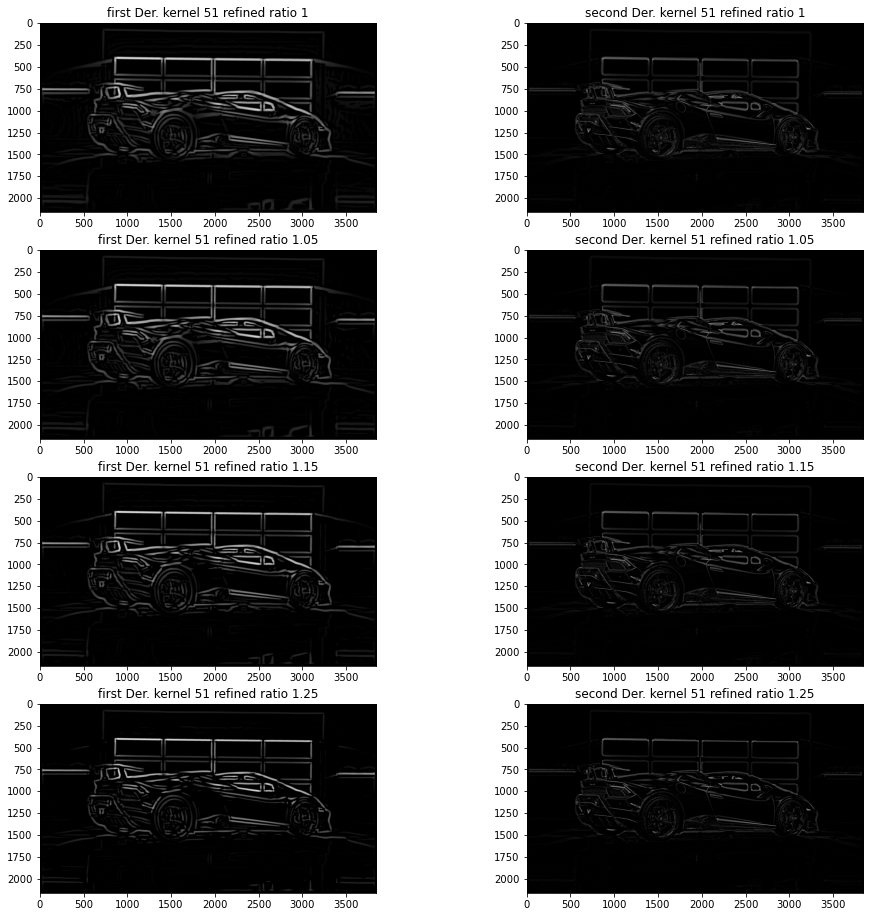

In [29]:
queuePlot = []
queueTile = []
w=10
h=10
fig=plt.figure(figsize=(16, 16))
columns = 2
rows = 4

queuePlot.append(l4D1k51R1)
queuePlot.append(l4D2k51R1)
queuePlot.append(l4D1k51R2)
queuePlot.append(l4D2k51R2)
queuePlot.append(l4D1k51R3)
queuePlot.append(l4D2k51R3)
queuePlot.append(l4D1k51R4)
queuePlot.append(l4D2k51R4)

queueTile.append("first Der. kernel 51 refined ratio 1")
queueTile.append("second Der. kernel 51 refined ratio 1")
queueTile.append("first Der. kernel 51 refined ratio 1.05")
queueTile.append("second Der. kernel 51 refined ratio 1.05")
queueTile.append("first Der. kernel 51 refined ratio 1.15")
queueTile.append("second Der. kernel 51 refined ratio 1.15")
queueTile.append("first Der. kernel 51 refined ratio 1.25")
queueTile.append("second Der. kernel 51 refined ratio 1.25")

for i in range(1, 8+1):
    fig.add_subplot(rows, columns, i)
    plt.title(queueTile.pop(0)) 
    plt.imshow(queuePlot.pop(0), cmap="gray")

plt.show()

# Refined edges for detected edge image with kernal size 101 wi refined edge with size 51 and different ratios

In [30]:
iil4D1k101 = CalculateIntegral(l4D1k101)
iil4D2k101 = CalculateIntegral(l4D2k101)

l4D1k101R1 = RefineEdge(iil4D1k101, 51, 1)
l4D2k101R1 = RefineEdge(iil4D2k101, 51, 1)

l4D1k101R2 = RefineEdge(iil4D1k101, 51, 1.05)
l4D2k101R2 = RefineEdge(iil4D2k101, 51, 1.05)

l4D1k101R3 = RefineEdge(iil4D1k101, 51, 1.15)
l4D2k101R3 = RefineEdge(iil4D2k101, 51, 1.15)

l4D1k101R4 = RefineEdge(iil4D1k101, 51, 1.25)
l4D2k101R4 = RefineEdge(iil4D2k101, 51, 1.25)

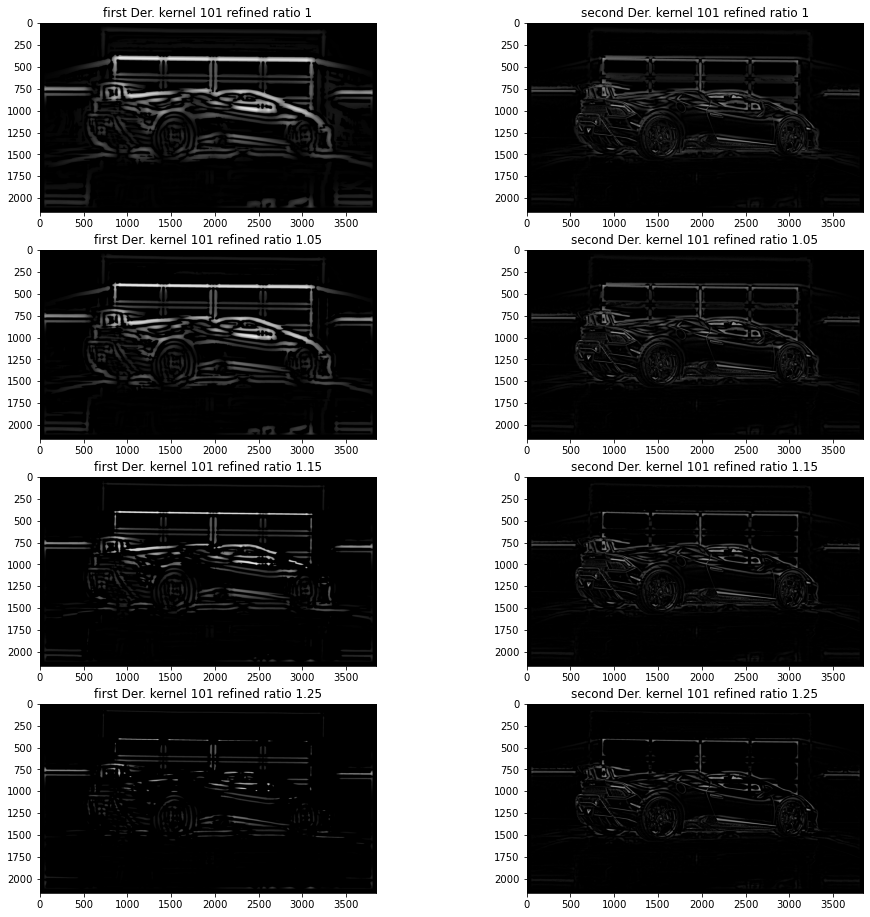

In [31]:
queuePlot = []
queueTile = []
w=10
h=10
fig=plt.figure(figsize=(16, 16))
columns = 2
rows = 4

queuePlot.append(l4D1k101R1)
queuePlot.append(l4D2k101R1)
queuePlot.append(l4D1k101R2)
queuePlot.append(l4D2k101R2)
queuePlot.append(l4D1k101R3)
queuePlot.append(l4D2k101R3)
queuePlot.append(l4D1k101R4)
queuePlot.append(l4D2k101R4)

queueTile.append("first Der. kernel 101 refined ratio 1")
queueTile.append("second Der. kernel 101 refined ratio 1")
queueTile.append("first Der. kernel 101 refined ratio 1.05")
queueTile.append("second Der. kernel 101 refined ratio 1.05")
queueTile.append("first Der. kernel 101 refined ratio 1.15")
queueTile.append("second Der. kernel 101 refined ratio 1.15")
queueTile.append("first Der. kernel 101 refined ratio 1.25")
queueTile.append("second Der. kernel 101 refined ratio 1.25")

for i in range(1, 8+1):
    fig.add_subplot(rows, columns, i)
    plt.title(queueTile.pop(0)) 
    plt.imshow(queuePlot.pop(0), cmap="gray")

plt.show()

# Refined edges for detected edge image with kernal size 121 wi refined edge with size 51 and different ratios

In [32]:
iil4D1k121 = CalculateIntegral(l4D1k121)
iil4D2k121 = CalculateIntegral(l4D2k121)

l4D1k121R1 = RefineEdge(iil4D1k121, 51, 1)
l4D2k121R1 = RefineEdge(iil4D2k121, 51, 1)

l4D1k121R2 = RefineEdge(iil4D1k121, 51, 1.05)
l4D2k121R2 = RefineEdge(iil4D2k121, 51, 1.05)

l4D1k121R3 = RefineEdge(iil4D1k121, 51, 1.15)
l4D2k121R3 = RefineEdge(iil4D2k121, 51, 1.15)

l4D1k121R4 = RefineEdge(iil4D1k121, 51, 1.25)
l4D2k121R4 = RefineEdge(iil4D2k121, 51, 1.25)

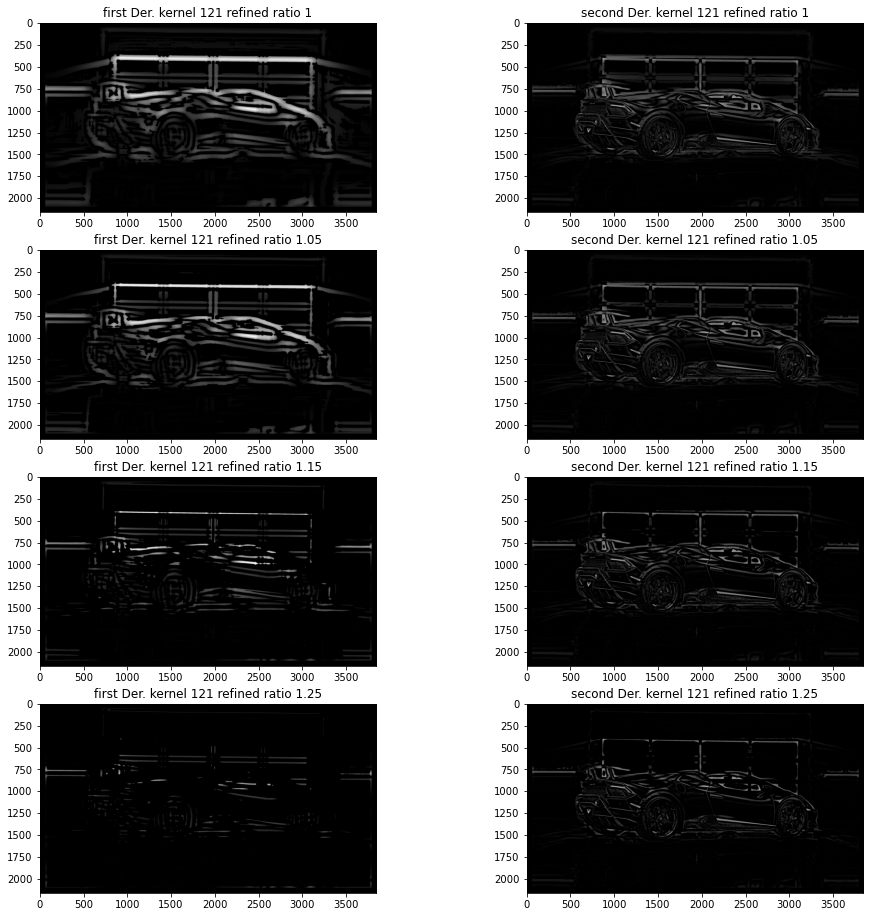

In [33]:
queuePlot = []
queueTile = []
w=10
h=10
fig=plt.figure(figsize=(16, 16))
columns = 2
rows = 4

queuePlot.append(l4D1k121R1)
queuePlot.append(l4D2k121R1)
queuePlot.append(l4D1k121R2)
queuePlot.append(l4D2k121R2)
queuePlot.append(l4D1k121R3)
queuePlot.append(l4D2k121R3)
queuePlot.append(l4D1k121R4)
queuePlot.append(l4D2k121R4)

queueTile.append("first Der. kernel 121 refined ratio 1")
queueTile.append("second Der. kernel 121 refined ratio 1")
queueTile.append("first Der. kernel 121 refined ratio 1.05")
queueTile.append("second Der. kernel 121 refined ratio 1.05")
queueTile.append("first Der. kernel 121 refined ratio 1.15")
queueTile.append("second Der. kernel 121 refined ratio 1.15")
queueTile.append("first Der. kernel 121 refined ratio 1.25")
queueTile.append("second Der. kernel 121 refined ratio 1.25")

for i in range(1, 8+1):
    fig.add_subplot(rows, columns, i)
    plt.title(queueTile.pop(0)) 
    plt.imshow(queuePlot.pop(0), cmap="gray")

plt.show()

# Plotting Results image L4B

# first and second deriv different kernel size 

In [34]:
# kernel size 11, 51, 101, and 121 first and second driv. for image 1

l4bD1k11, l4bD2k11 = EdgeDetect(iiL4b, 11)
l4bD1k51, l4bD2k51 = EdgeDetect(iiL4b, 51)
l4bD1k101, l4bD2k101 = EdgeDetect(iiL4b, 101)
l4bD1k121, l4bD2k121 = EdgeDetect(iiL4b, 121)

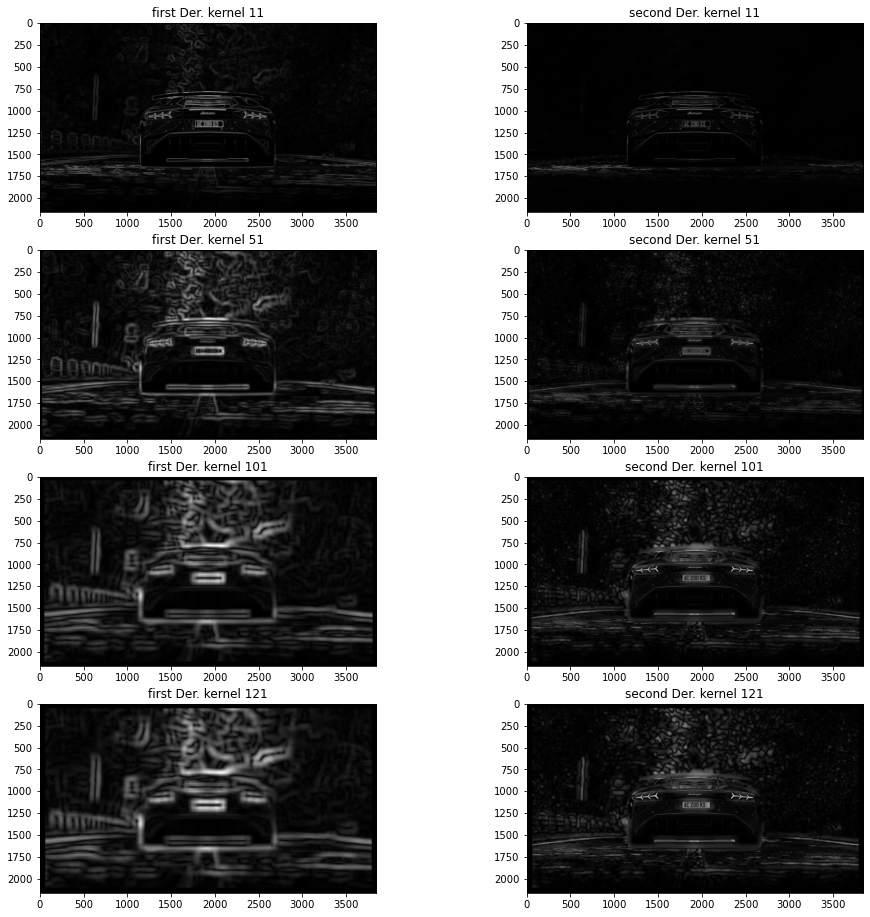

In [35]:
queuePlot = []
queueTile = []
w=10
h=10
fig=plt.figure(figsize=(16, 16))
columns = 2
rows = 4

queuePlot.append(l4bD1k11)
queuePlot.append(l4bD2k11)
queuePlot.append(l4bD1k51)
queuePlot.append(l4bD2k51)
queuePlot.append(l4bD1k101)
queuePlot.append(l4bD2k101)
queuePlot.append(l4bD1k121)
queuePlot.append(l4bD2k121)

queueTile.append("first Der. kernel 11")
queueTile.append("second Der. kernel 11")
queueTile.append("first Der. kernel 51")
queueTile.append("second Der. kernel 51")
queueTile.append("first Der. kernel 101")
queueTile.append("second Der. kernel 101")
queueTile.append("first Der. kernel 121")
queueTile.append("second Der. kernel 121")

for i in range(1, 8+1):
    fig.add_subplot(rows, columns, i)
    plt.title(queueTile.pop(0)) 
    plt.imshow(queuePlot.pop(0), cmap="gray")

plt.show()

# Refined edges for detected edge image with kernal size 11 wi refined edge with size 51 and different ratios

In [37]:
iil4bD1k11 = CalculateIntegral(l4bD1k11)
iil4bD2k11 = CalculateIntegral(l4bD2k11)

l4bD1k11R1 = RefineEdge(iil4bD1k11, 51, 1)
l4bD2k11R1 = RefineEdge(iil4bD2k11, 51, 1)

l4bD1k11R2 = RefineEdge(iil4bD1k11, 51, 1.05)
l4bD2k11R2 = RefineEdge(iil4bD2k11, 51, 1.05)

l4bD1k11R3 = RefineEdge(iil4bD1k11, 51, 1.15)
l4bD2k11R3 = RefineEdge(iil4bD2k11, 51, 1.15)

l4bD1k11R4 = RefineEdge(iil4bD1k11, 51, 1.25)
l4bD2k11R4 = RefineEdge(iil4bD2k11, 51, 1.25)

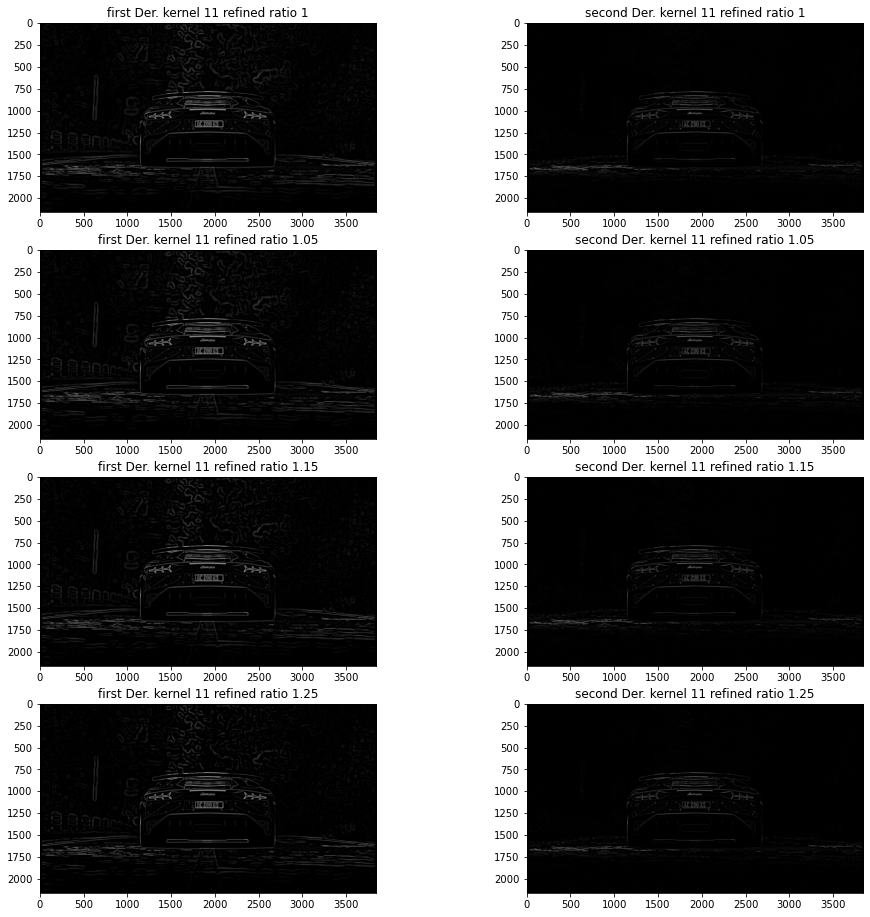

In [38]:
queuePlot = []
queueTile = []
w=10
h=10
fig=plt.figure(figsize=(16, 16))
columns = 2
rows = 4

queuePlot.append(l4bD1k11R1)
queuePlot.append(l4bD2k11R1)
queuePlot.append(l4bD1k11R2)
queuePlot.append(l4bD2k11R2)
queuePlot.append(l4bD1k11R3)
queuePlot.append(l4bD2k11R3)
queuePlot.append(l4bD1k11R4)
queuePlot.append(l4bD2k11R4)

queueTile.append("first Der. kernel 11 refined ratio 1")
queueTile.append("second Der. kernel 11 refined ratio 1")
queueTile.append("first Der. kernel 11 refined ratio 1.05")
queueTile.append("second Der. kernel 11 refined ratio 1.05")
queueTile.append("first Der. kernel 11 refined ratio 1.15")
queueTile.append("second Der. kernel 11 refined ratio 1.15")
queueTile.append("first Der. kernel 11 refined ratio 1.25")
queueTile.append("second Der. kernel 11 refined ratio 1.25")

for i in range(1, 8+1):
    fig.add_subplot(rows, columns, i)
    plt.title(queueTile.pop(0)) 
    plt.imshow(queuePlot.pop(0), cmap="gray")

plt.show()

# Refined edges for detected edge image with kernal size 51 wi refined edge with size 51 and different ratios

In [39]:
iil4bD1k51 = CalculateIntegral(l4bD1k51)
iil4bD2k51 = CalculateIntegral(l4bD2k51)

l4bD1k51R1 = RefineEdge(iil4bD1k51, 51, 1)
l4bD2k51R1 = RefineEdge(iil4bD2k51, 51, 1)

l4bD1k51R2 = RefineEdge(iil4bD1k51, 51, 1.05)
l4bD2k51R2 = RefineEdge(iil4bD2k51, 51, 1.05)

l4bD1k51R3 = RefineEdge(iil4bD1k51, 51, 1.15)
l4bD2k51R3 = RefineEdge(iil4bD2k51, 51, 1.15)

l4bD1k51R4 = RefineEdge(iil4bD1k51, 51, 1.25)
l4bD2k51R4 = RefineEdge(iil4bD2k51, 51, 1.25)

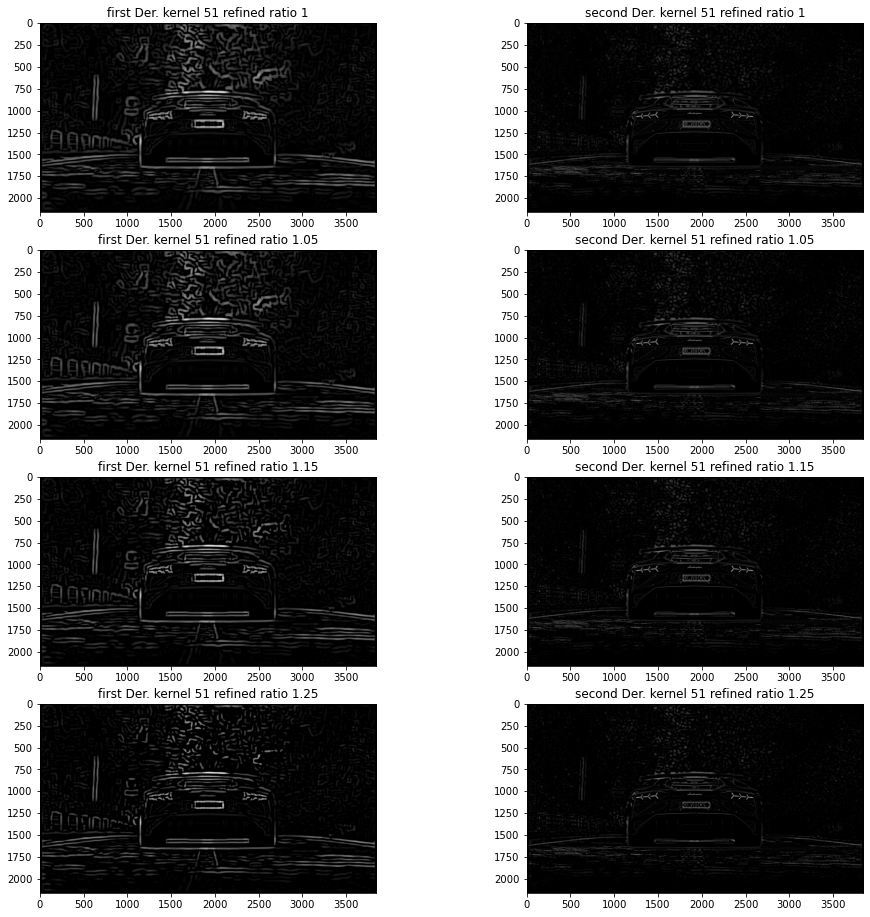

In [40]:
queuePlot = []
queueTile = []
w=10
h=10
fig=plt.figure(figsize=(16, 16))
columns = 2
rows = 4

queuePlot.append(l4bD1k51R1)
queuePlot.append(l4bD2k51R1)
queuePlot.append(l4bD1k51R2)
queuePlot.append(l4bD2k51R2)
queuePlot.append(l4bD1k51R3)
queuePlot.append(l4bD2k51R3)
queuePlot.append(l4bD1k51R4)
queuePlot.append(l4bD2k51R4)

queueTile.append("first Der. kernel 51 refined ratio 1")
queueTile.append("second Der. kernel 51 refined ratio 1")
queueTile.append("first Der. kernel 51 refined ratio 1.05")
queueTile.append("second Der. kernel 51 refined ratio 1.05")
queueTile.append("first Der. kernel 51 refined ratio 1.15")
queueTile.append("second Der. kernel 51 refined ratio 1.15")
queueTile.append("first Der. kernel 51 refined ratio 1.25")
queueTile.append("second Der. kernel 51 refined ratio 1.25")

for i in range(1, 8+1):
    fig.add_subplot(rows, columns, i)
    plt.title(queueTile.pop(0)) 
    plt.imshow(queuePlot.pop(0), cmap="gray")

plt.show()

# Refined edges for detected edge image with kernal size 101 wi refined edge with size 51 and different ratios

In [41]:
iil4bD1k101 = CalculateIntegral(l4bD1k101)
iil4bD2k101 = CalculateIntegral(l4bD2k101)

l4bD1k101R1 = RefineEdge(iil4bD1k101, 51, 1)
l4bD2k101R1 = RefineEdge(iil4bD2k101, 51, 1)

l4bD1k101R2 = RefineEdge(iil4bD1k101, 51, 1.05)
l4bD2k101R2 = RefineEdge(iil4bD2k101, 51, 1.05)

l4bD1k101R3 = RefineEdge(iil4bD1k101, 51, 1.15)
l4bD2k101R3 = RefineEdge(iil4bD2k101, 51, 1.15)

l4bD1k101R4 = RefineEdge(iil4bD1k101, 51, 1.25)
l4bD2k101R4 = RefineEdge(iil4bD2k101, 51, 1.25)

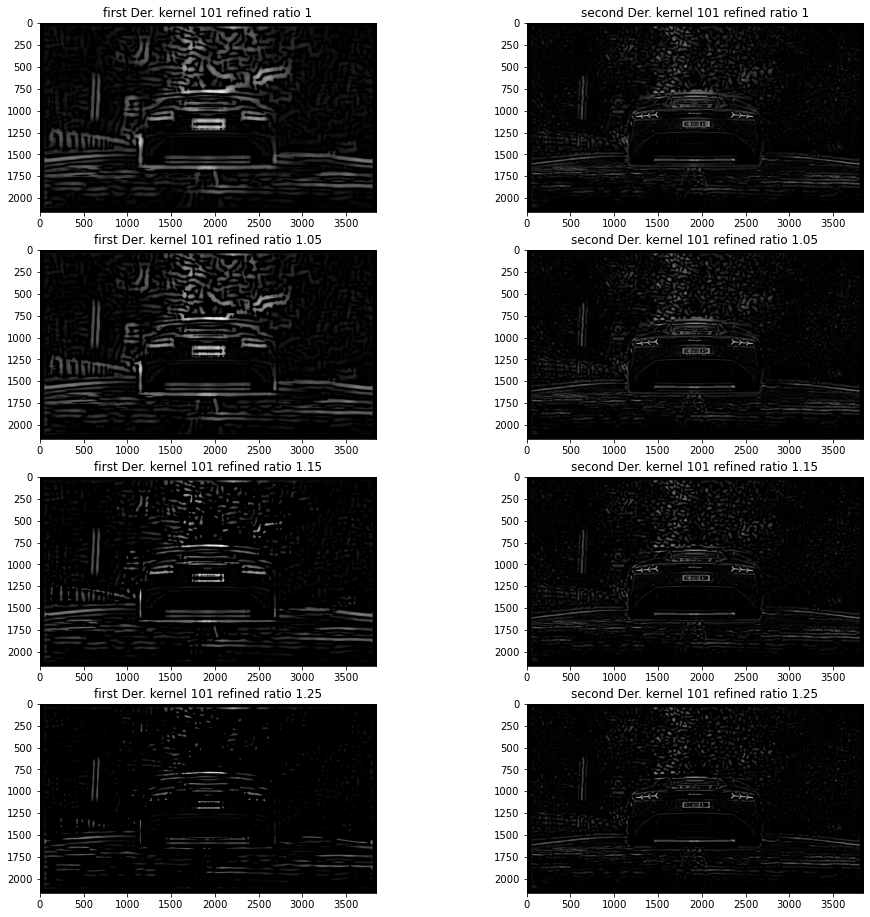

In [42]:
queuePlot = []
queueTile = []
w=10
h=10
fig=plt.figure(figsize=(16, 16))
columns = 2
rows = 4

queuePlot.append(l4bD1k101R1)
queuePlot.append(l4bD2k101R1)
queuePlot.append(l4bD1k101R2)
queuePlot.append(l4bD2k101R2)
queuePlot.append(l4bD1k101R3)
queuePlot.append(l4bD2k101R3)
queuePlot.append(l4bD1k101R4)
queuePlot.append(l4bD2k101R4)

queueTile.append("first Der. kernel 101 refined ratio 1")
queueTile.append("second Der. kernel 101 refined ratio 1")
queueTile.append("first Der. kernel 101 refined ratio 1.05")
queueTile.append("second Der. kernel 101 refined ratio 1.05")
queueTile.append("first Der. kernel 101 refined ratio 1.15")
queueTile.append("second Der. kernel 101 refined ratio 1.15")
queueTile.append("first Der. kernel 101 refined ratio 1.25")
queueTile.append("second Der. kernel 101 refined ratio 1.25")

for i in range(1, 8+1):
    fig.add_subplot(rows, columns, i)
    plt.title(queueTile.pop(0)) 
    plt.imshow(queuePlot.pop(0), cmap="gray")

plt.show()

# Refined edges for detected edge image with kernal size 121 wi refined edge with size 51 and different ratios

In [43]:
iil4bD1k121 = CalculateIntegral(l4bD1k121)
iil4bD2k121 = CalculateIntegral(l4bD2k121)

l4bD1k121R1 = RefineEdge(iil4bD1k121, 51, 1)
l4bD2k121R1 = RefineEdge(iil4bD2k121, 51, 1)

l4bD1k121R2 = RefineEdge(iil4bD1k121, 51, 1.05)
l4bD2k121R2 = RefineEdge(iil4bD2k121, 51, 1.05)

l4bD1k121R3 = RefineEdge(iil4bD1k121, 51, 1.15)
l4bD2k121R3 = RefineEdge(iil4bD2k121, 51, 1.15)

l4bD1k121R4 = RefineEdge(iil4bD1k121, 51, 1.25)
l4bD2k121R4 = RefineEdge(iil4bD2k121, 51, 1.25)

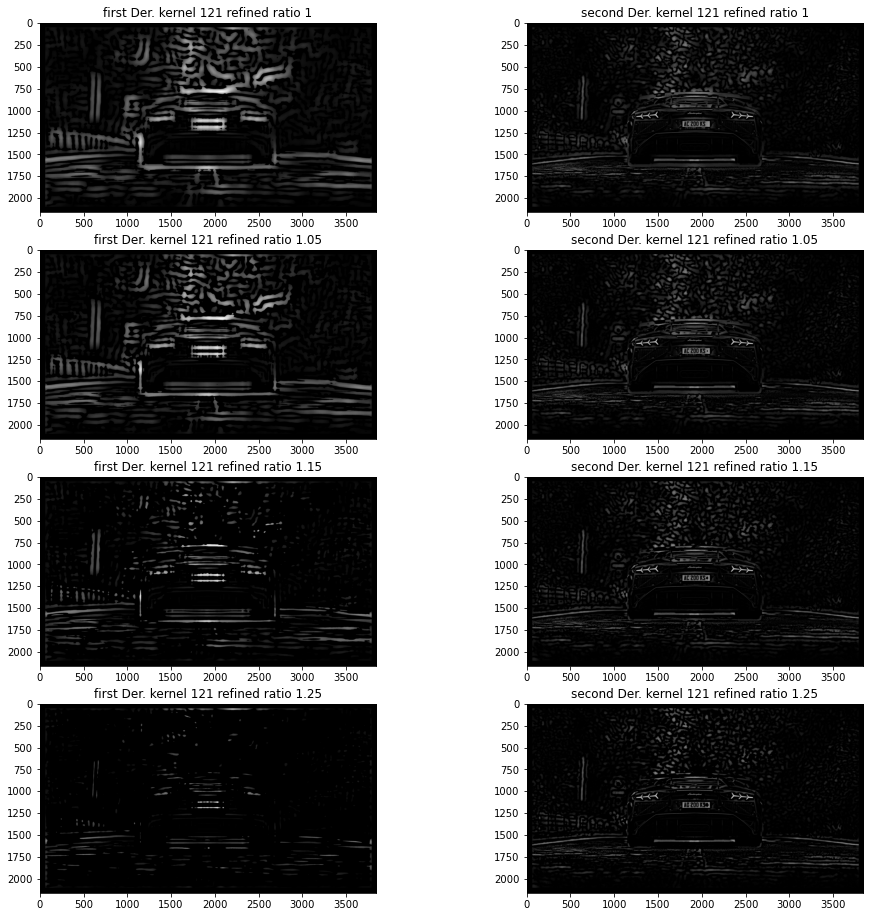

In [44]:
queuePlot = []
queueTile = []
w=10
h=10
fig=plt.figure(figsize=(16, 16))
columns = 2
rows = 4

queuePlot.append(l4bD1k121R1)
queuePlot.append(l4bD2k121R1)
queuePlot.append(l4bD1k121R2)
queuePlot.append(l4bD2k121R2)
queuePlot.append(l4bD1k121R3)
queuePlot.append(l4bD2k121R3)
queuePlot.append(l4bD1k121R4)
queuePlot.append(l4bD2k121R4)

queueTile.append("first Der. kernel 121 refined ratio 1")
queueTile.append("second Der. kernel 121 refined ratio 1")
queueTile.append("first Der. kernel 121 refined ratio 1.05")
queueTile.append("second Der. kernel 121 refined ratio 1.05")
queueTile.append("first Der. kernel 121 refined ratio 1.15")
queueTile.append("second Der. kernel 121 refined ratio 1.15")
queueTile.append("first Der. kernel 121 refined ratio 1.25")
queueTile.append("second Der. kernel 121 refined ratio 1.25")

for i in range(1, 8+1):
    fig.add_subplot(rows, columns, i)
    plt.title(queueTile.pop(0)) 
    plt.imshow(queuePlot.pop(0), cmap="gray")

plt.show()